In [1]:
import math
import torch
import gpytorch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import GPE_ensemble as GPE

from time import process_time 

from GPErks.gp.experiment import GPExperiment
from GPErks.train.emulator import GPEmulator
from GPErks.perks.inference import Inference
from GPErks.train.early_stop import NoEarlyStoppingCriterion
from GPErks.train.early_stop import (
    GLEarlyStoppingCriterion,
    PQEarlyStoppingCriterion,
    UPEarlyStoppingCriterion, 
)
from GPErks.train.early_stop import PkEarlyStoppingCriterion

import scipy

%matplotlib inline
%load_ext autoreload
%autoreload 2

from sklearn.model_selection import train_test_split

# set logger and enforce reproducibility
from GPErks.log.logger import get_logger
from GPErks.utils.random import set_seed
log = get_logger()
seed = 8
set_seed(seed)

In [2]:
mode_weights = pd.read_csv(r'C:\Users\pmzcwl\Documents\GitHub\Calibration\modes_weights.csv',index_col=0,delim_whitespace=False,header=0)

In [3]:
mode_weights

,Mode1,Mode2,Mode3,Mode4,Mode5,Mode6,Mode7,Mode8,Mode9,Mode10,Mode11,Mode12,Mode13,Mode14,Mode15,Mode16,Mode17,Mode18
Mesh_ID,,,,,,,,,,,,,,,,,,
1,-26.526282,-21.987510,45.298672,6.964297,1.264487,-14.710058,2.926209,0.175002,23.694737,3.505879,0.634389,5.188583,0.952835,-1.595273,1.443640,-0.904097,-1.312873,-0.395244
2,-16.902798,23.644504,19.452896,-24.329813,-25.447350,20.415574,-8.318264,-11.552292,4.878743,-0.590770,0.058564,-5.180545,0.202458,5.183101,1.159655,-4.124027,-1.797792,1.839387
3,14.528402,16.328970,-5.269040,31.653975,7.173021,17.494031,-1.362727,-2.515712,3.296703,-3.384570,6.019192,6.381015,12.668005,2.272989,-7.823127,-3.264168,-0.556074,-3.457493
4,-15.076964,28.889168,8.644859,4.758042,1.301095,5.983310,-12.741057,29.428944,0.900375,-3.117595,5.360741,-4.384879,-5.052080,-0.322429,1.764566,0.281199,0.379901,1.411104
5,-3.839848,-47.723637,7.042452,-4.914959,-4.014415,20.366371,1.061045,3.789887,-4.468229,4.581192,-5.260154,-1.138816,0.222769,-9.960540,-3.465097,8.679472,-5.080536,-3.130734
6,18.372208,-13.173184,-10.191443,-24.148353,5.156296,-5.613573,5.256249,6.128060,2.273913,-3.308190,-1.089152,5.115009,-2.514505,15.535679,-6.383510,4.925573,-2.114735,-5.143046
7,-34.355273,-16.804885,-6.838693,-12.785964,5.546781,-11.206395,-10.998304,2.434263,-4.587426,1.445966,-7.883546,-10.294014,11.979958,-1.239739,-1.025227,-5.488834,6.809864,-5.501627
8,-25.433101,7.377060,16.518874,10.553323,20.454561,-3.834116,8.557983,-6.411704,-8.757667,-9.300747,-1.650785,-11.269317,3.099298,4.335249,5.748891,3.315503,-8.408521,3.104817
9,23.260333,-15.185501,34.509394,-5.474826,-7.066281,-10.593615,5.997680,0.089632,-18.393991,4.721930,14.410537,1.322375,0.474351,-0.843182,-6.305262,-3.498095,1.827012,3.739217


In [4]:
mode_weights=mode_weights.drop(15,axis=0)
#mode_weights=mode_weights.drop(14,axis=0)

In [5]:
meshes=['01','02','03','04','05','06','07','08','09','10','11','12','13','14','16','17','18','19']

In [6]:
pd.read_csv("/Users/pmzcwl/Documents/GitHub/Calibration/shared_simulations/EP_healthy/"+meshes[0]+"/X_EP.txt",index_col=None,delim_whitespace=True,header=None).values

array([[0.487005, 0.321104, 6.56834 , 0.799039, 0.47051 , 5.04917 ],
       [0.649337, 0.34538 , 4.40605 , 0.311586, 0.313059, 4.37368 ],
       [0.666146, 0.43197 , 7.48917 , 0.996915, 0.20351 , 3.88357 ],
       ...,
       [0.659101, 0.299998, 1.80109 , 0.605964, 0.456326, 1.19854 ],
       [0.597605, 0.258533, 4.64056 , 0.54075 , 0.336259, 5.12383 ],
       [0.639472, 0.344217, 2.96581 , 0.654483, 0.385298, 3.01703 ]])

In [7]:
mode_weights.iloc[2,:]

Mode1     14.528402
Mode2     16.328970
Mode3     -5.269040
Mode4     31.653975
Mode5      7.173021
Mode6     17.494031
Mode7     -1.362727
Mode8     -2.515712
Mode9      3.296703
Mode10    -3.384570
Mode11     6.019192
Mode12     6.381015
Mode13    12.668005
Mode14     2.272989
Mode15    -7.823127
Mode16    -3.264168
Mode17    -0.556074
Mode18    -3.457493
Name: 3, dtype: float64

In [8]:
mode_weights.iloc[0,:].values.shape[0]

18

In [9]:
x_labels=pd.read_csv(r'C:\Users\pmzcwl\Documents\GitHub\Calibration\shared_simulations\EP_healthy\input\xlabels_EP.txt',delim_whitespace=True,header=None)
x_labels=x_labels.values.flatten().tolist()+mode_weights.columns.tolist()

In [10]:
y_labels=pd.read_csv(r'C:\Users\pmzcwl\Documents\GitHub\Calibration\shared_simulations\EP_healthy\output\ylabels.txt',delim_whitespace=True,header=None)

In [11]:
all_input = []
all_output=[]
for i in range(len(meshes)):
    val=meshes[i]
    
    inputData = pd.read_csv("/Users/pmzcwl/Documents/GitHub/Calibration/shared_simulations/EP_healthy/"+val+"/X_EP.txt",index_col=None,delim_whitespace=True,header=None).values
    outputData = pd.read_csv("/Users/pmzcwl/Documents/GitHub/Calibration/shared_simulations/EP_healthy/"+val+"/Y.txt",index_col=None,delim_whitespace=True,header=None).values
    modeweights = np.tile(mode_weights.iloc[i,:].values, (inputData.shape[0],1))
    input_modes = np.concatenate((inputData,modeweights),axis=1)
    all_input.append(pd.DataFrame(input_modes))
    all_output.append(pd.DataFrame(outputData))
    print(val)
    print(np.max(outputData))
all_input=pd.concat(all_input)
all_output=pd.concat(all_output)
all_input.columns=x_labels
all_output.columns=y_labels

01
406.703
02
317.407
03
332.914
04
309.14
05
277.849
06
296.377
07
355.546
08
283.103
09
391.145
10
439.316
11
348.01
12
292.465
13
301.222
14
325.678
16
297.968
17
317.709
18
297.346
19
312.492


In [12]:
all_input=all_input.iloc[:,0:15]

In [13]:
new_mode_weights = pd.read_csv(r'C:\Users\pmzcwl\Documents\GitHub\Calibration\shared_simulations\shape_EP\X_shape.txt',delim_whitespace=True,header=None)

In [14]:
new_EP = pd.read_csv(r'C:\Users\pmzcwl\Documents\GitHub\Calibration\shared_simulations\shape_EP\X_EP.txt',delim_whitespace=True,header=None)

In [15]:
new_Y = pd.read_csv(r'C:\Users\pmzcwl\Documents\GitHub\Calibration\shared_simulations\shape_EP\Y.txt',delim_whitespace=True,header=None)

In [16]:
new_X = pd.DataFrame(np.concatenate((new_EP,new_mode_weights),axis=1))

In [17]:
x_labels

['CV_ventricles',
 'k_ventricles',
 'k_FEC',
 'CV_atria',
 'k_atria',
 'k_BB',
 'Mode1',
 'Mode2',
 'Mode3',
 'Mode4',
 'Mode5',
 'Mode6',
 'Mode7',
 'Mode8',
 'Mode9',
 'Mode10',
 'Mode11',
 'Mode12',
 'Mode13',
 'Mode14',
 'Mode15',
 'Mode16',
 'Mode17',
 'Mode18']

In [18]:
new_X.columns=x_labels[0:15]
new_Y.columns=y_labels

In [19]:
# convert all columns to numeric format
new_Y = new_Y.apply(pd.to_numeric, errors='coerce')

# identify non-numeric rows
non_numeric_rows = new_Y.isnull().any(axis=1)
non_numeric_rows=non_numeric_rows[non_numeric_rows==1]

In [20]:
non_numeric_rows.index

Index([ 16,  29,  53,  54,  67,  74,  86,  97, 101, 116, 137, 177, 180, 185,
       190, 210, 215, 232, 255, 260, 263, 273, 290],
      dtype='int64')

In [21]:
new_Y.shape

(300, 2)

In [22]:
new_X.shape

(300, 15)

In [23]:
new_Y=new_Y.drop(non_numeric_rows.index)

In [24]:
new_X=new_X.drop(non_numeric_rows.index)

In [25]:
new_Y.shape

(277, 2)

In [26]:
new_X.shape

(277, 15)

In [27]:
new_Y.shape[0]

277

In [28]:
np.min(new_X,axis=0)

CV_ventricles     0.380243
k_ventricles      0.200699
k_FEC             1.209630
CV_atria          0.304326
k_atria           0.201144
k_BB              1.013930
Mode1           -98.407900
Mode2           -72.394700
Mode3           -56.098900
Mode4           -38.305300
Mode5           -38.188600
Mode6           -23.461100
Mode7           -30.602400
Mode8           -21.600200
Mode9           -28.823700
dtype: float64

In [29]:
np.max(new_X,axis=0)

CV_ventricles      0.798761
k_ventricles       0.499050
k_FEC              8.383950
CV_atria           1.028690
k_atria            0.499212
k_BB               5.693100
Mode1            115.841000
Mode2             76.588200
Mode3             65.456700
Mode4             45.329800
Mode5             38.399900
Mode6             29.104600
Mode7             38.780800
Mode8             39.547500
Mode9             34.202600
dtype: float64

In [30]:
# split original dataset in training, validation and testing sets
X=all_input
y=all_output
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.8,
    random_state=seed
)

In [31]:
(new_X.loc[:, ~(new_X.columns.isin(['k_FEC', 'k_atria','k_BB']))])

,CV_ventricles,k_ventricles,CV_atria,Mode1,Mode2,Mode3,Mode4,Mode5,Mode6,Mode7,Mode8,Mode9
0,0.641236,0.232269,0.443540,-74.75940,-55.89050,24.3460,3.37582,-9.996060,15.818400,8.52706,-21.42750,-5.03404
1,0.395176,0.316248,0.873246,84.82910,-9.85172,24.7688,-38.30530,16.453500,15.967400,-19.49230,23.47400,17.73220
2,0.750663,0.466851,0.883430,-44.56040,-52.04740,-20.6696,36.80330,21.216800,-18.285000,9.76596,17.48210,-15.44370
3,0.515384,0.278379,0.608156,-9.43475,50.90310,59.6060,-36.17250,37.072200,-22.716700,7.03628,37.70620,20.91580
4,0.672058,0.298497,0.571429,53.31340,39.46160,43.9669,-0.07547,-25.002800,-1.744160,-25.75200,-12.21970,-14.19810
...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.599927,0.345675,0.717018,-2.11294,-21.06400,15.1948,-22.72070,-3.498760,22.791200,-16.34690,-11.96790,-21.11080
296,0.622506,0.389399,0.541856,-98.40790,-60.63980,44.3296,-5.23373,-32.044700,28.438300,-21.26990,-16.58980,24.46710
297,0.614974,0.292916,0.686499,-13.79420,5.90648,17.6619,28.77770,-28.190800,21.014600,-13.31350,5.40629,-18.02050
298,0.793522,0.326869,1.016910,-30.75890,74.06550,38.4023,10.25170,0.779017,19.656200,30.82260,-13.38260,26.33450


In [32]:
emulator = GPE.ensemble((new_X.loc[:, ~(new_X.columns.isin(['k_FEC', 'k_atria','k_BB']))]),new_Y,mean_func="linear",training_iter=500)

0
1


In [33]:
X_test_split =all_input.iloc[[400]]
y_test_split = all_output.iloc[[400]]

In [34]:
X_test_split

,CV_ventricles,k_ventricles,k_FEC,CV_atria,k_atria,k_BB,Mode1,Mode2,Mode3,Mode4,Mode5,Mode6,Mode7,Mode8,Mode9
40,0.727054,0.407562,2.2459,0.515077,0.332962,4.3567,14.528402,16.32897,-5.26904,31.653975,7.173021,17.494031,-1.362727,-2.515712,3.296703


In [35]:
y_test_split

,"(A_TAT,)","(V_TAT,)"
40,153.388,84.0788


In [36]:
Nx = 10

In [37]:
CV_V = np.linspace(0.4,0.8,Nx)
k_v = np.linspace(0.2,0.5,Nx)
k_fec = np.linspace(1.2,8.4,Nx)
CV_A = np.linspace(0.3,1,Nx)


In [38]:
CV_V3,k_v3,k_fec3 = np.meshgrid(CV_V,k_v,k_fec)

In [39]:
CV_V3,k_v3,CV_A3 = np.meshgrid(CV_V,k_v,CV_A,indexing='xy')

In [40]:
CV_V3

array([[[0.4       , 0.4       , 0.4       , 0.4       , 0.4       ,
         0.4       , 0.4       , 0.4       , 0.4       , 0.4       ],
        [0.44444444, 0.44444444, 0.44444444, 0.44444444, 0.44444444,
         0.44444444, 0.44444444, 0.44444444, 0.44444444, 0.44444444],
        [0.48888889, 0.48888889, 0.48888889, 0.48888889, 0.48888889,
         0.48888889, 0.48888889, 0.48888889, 0.48888889, 0.48888889],
        [0.53333333, 0.53333333, 0.53333333, 0.53333333, 0.53333333,
         0.53333333, 0.53333333, 0.53333333, 0.53333333, 0.53333333],
        [0.57777778, 0.57777778, 0.57777778, 0.57777778, 0.57777778,
         0.57777778, 0.57777778, 0.57777778, 0.57777778, 0.57777778],
        [0.62222222, 0.62222222, 0.62222222, 0.62222222, 0.62222222,
         0.62222222, 0.62222222, 0.62222222, 0.62222222, 0.62222222],
        [0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667,
         0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667],
        [0.71111111, 0.7111

In [41]:
g = np.meshgrid(CV_V,k_v,CV_A,indexing='ij')
positions = np.vstack(map(np.ravel, g))

C:\Users\pmzcwl\AppData\Local\Temp\ipykernel_3332\807067843.py:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  positions = np.vstack(map(np.ravel, g))


In [42]:
positions

array([[0.4       , 0.4       , 0.4       , ..., 0.8       , 0.8       ,
        0.8       ],
       [0.2       , 0.2       , 0.2       , ..., 0.5       , 0.5       ,
        0.5       ],
       [0.3       , 0.37777778, 0.45555556, ..., 0.84444444, 0.92222222,
        1.        ]])

In [43]:
newdf = pd.DataFrame(np.repeat(X_test_split.values, Nx**3, axis=0))#+np.random.multivariate_normal(mean=np.zeros(6), cov=0.01*np.identity(6), size=100)
newdf.columns = X_test_split.columns
#print(newdf)

In [44]:
newdf.iloc[:,[0,1,3]] = positions.T

In [45]:
#newdf.iloc[:,0] = CV_V3.reshape(Nx**3)
#newdf.iloc[:,1] = k_v3.reshape(Nx**3)
#newdf.iloc[:,3] = CV_A3.reshape(Nx**3)

newdf=(newdf.loc[:, ~(newdf.columns.isin(['k_FEC', 'k_atria','k_BB']))])

In [46]:
newdf

,CV_ventricles,k_ventricles,CV_atria,Mode1,Mode2,Mode3,Mode4,Mode5,Mode6,Mode7,Mode8,Mode9
0,0.4,0.2,0.300000,14.528402,16.32897,-5.26904,31.653975,7.173021,17.494031,-1.362727,-2.515712,3.296703
1,0.4,0.2,0.377778,14.528402,16.32897,-5.26904,31.653975,7.173021,17.494031,-1.362727,-2.515712,3.296703
2,0.4,0.2,0.455556,14.528402,16.32897,-5.26904,31.653975,7.173021,17.494031,-1.362727,-2.515712,3.296703
3,0.4,0.2,0.533333,14.528402,16.32897,-5.26904,31.653975,7.173021,17.494031,-1.362727,-2.515712,3.296703
4,0.4,0.2,0.611111,14.528402,16.32897,-5.26904,31.653975,7.173021,17.494031,-1.362727,-2.515712,3.296703
...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.8,0.5,0.688889,14.528402,16.32897,-5.26904,31.653975,7.173021,17.494031,-1.362727,-2.515712,3.296703
996,0.8,0.5,0.766667,14.528402,16.32897,-5.26904,31.653975,7.173021,17.494031,-1.362727,-2.515712,3.296703
997,0.8,0.5,0.844444,14.528402,16.32897,-5.26904,31.653975,7.173021,17.494031,-1.362727,-2.515712,3.296703
998,0.8,0.5,0.922222,14.528402,16.32897,-5.26904,31.653975,7.173021,17.494031,-1.362727,-2.515712,3.296703


In [47]:
data = emulator.predict(newdf).detach().numpy()[:,1].reshape(Nx,Nx,Nx)

In [48]:
y_rep = pd.DataFrame(np.repeat(y_test_split.values, Nx**3, axis=0))
y_rep.columns = y_test.columns
print(y_rep)

     (A_TAT,)  (V_TAT,)
0     153.388   84.0788
1     153.388   84.0788
2     153.388   84.0788
3     153.388   84.0788
4     153.388   84.0788
..        ...       ...
995   153.388   84.0788
996   153.388   84.0788
997   153.388   84.0788
998   153.388   84.0788
999   153.388   84.0788

[1000 rows x 2 columns]


In [49]:
newdf_norm, y_rep_norm = emulator.normalise_test_data(newdf,y_rep)

In [50]:
emulator.training_output_STD

(A_TAT,)    61.444822
(V_TAT,)    31.250671
dtype: float64

In [51]:
y_rep_norm

,"(A_TAT,)","(V_TAT,)"
0,0.136097,-0.828239
1,0.136097,-0.828239
2,0.136097,-0.828239
3,0.136097,-0.828239
4,0.136097,-0.828239
...,...,...
995,0.136097,-0.828239
996,0.136097,-0.828239
997,0.136097,-0.828239
998,0.136097,-0.828239


In [52]:
newdf_norm

,CV_ventricles,k_ventricles,CV_atria,Mode1,Mode2,Mode3,Mode4,Mode5,Mode6,Mode7,Mode8,Mode9
0,-1.560390,-1.702565,-1.773647,0.14114,0.308525,-0.318869,1.203958,0.295008,0.999442,-0.292557,-0.633733,0.060343
1,-1.560390,-1.702565,-1.402653,0.14114,0.308525,-0.318869,1.203958,0.295008,0.999442,-0.292557,-0.633733,0.060343
2,-1.560390,-1.702565,-1.031658,0.14114,0.308525,-0.318869,1.203958,0.295008,0.999442,-0.292557,-0.633733,0.060343
3,-1.560390,-1.702565,-0.660664,0.14114,0.308525,-0.318869,1.203958,0.295008,0.999442,-0.292557,-0.633733,0.060343
4,-1.560390,-1.702565,-0.289670,0.14114,0.308525,-0.318869,1.203958,0.295008,0.999442,-0.292557,-0.633733,0.060343
...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.706693,1.721297,0.081325,0.14114,0.308525,-0.318869,1.203958,0.295008,0.999442,-0.292557,-0.633733,0.060343
996,1.706693,1.721297,0.452319,0.14114,0.308525,-0.318869,1.203958,0.295008,0.999442,-0.292557,-0.633733,0.060343
997,1.706693,1.721297,0.823313,0.14114,0.308525,-0.318869,1.203958,0.295008,0.999442,-0.292557,-0.633733,0.060343
998,1.706693,1.721297,1.194308,0.14114,0.308525,-0.318869,1.203958,0.295008,0.999442,-0.292557,-0.633733,0.060343


In [53]:
y_rep_norm.iloc[[0]].iloc[:,0].values

array([0.13609663])

In [54]:
print(emulator.ensemble_likelihood(newdf_norm.iloc[[25]],y_rep_norm.iloc[[25]]))

[2.73655037e-16 0.00000000e+00]


In [55]:
mll1 = gpytorch.mlls.ExactMarginalLogLikelihood(emulator.likelihoods[1], emulator.models[1])
mll0 = gpytorch.mlls.ExactMarginalLogLikelihood(emulator.likelihoods[0], emulator.models[0])

In [56]:
t1_start = process_time() 
likelihood = np.zeros(Nx**3)
likelihood2 = np.zeros(Nx**3)
for i in range(Nx**3):
    likelihood[i]=np.exp(mll1(emulator.models[1](torch.tensor(newdf_norm.iloc[[i]].values).float()),torch.tensor(y_rep_norm.iloc[i,1]).float()).detach().numpy())*np.exp(mll0(emulator.models[0](torch.tensor(newdf_norm.iloc[[i]].values).float()),torch.tensor(y_rep_norm.iloc[i,0 ]).float()).detach().numpy())
    likelihood2[i] = np.prod(emulator.ensemble_likelihood(newdf.iloc[[i]],y_rep.iloc[[i]]))
    print(i)
t1_stop = process_time() 
   
print("Elapsed time:", t1_stop, t1_start)  
   
print("Elapsed time during the whole program in seconds:", 
                                         t1_stop-t1_start)   

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [57]:
likelihood

array([1.25018185e-16, 1.49867884e-13, 1.14596154e-11, 4.06154554e-11,
       3.31954429e-11, 1.78186736e-11, 9.59951996e-12, 6.00821693e-12,
       3.83237973e-12, 1.78547227e-12, 6.15724449e-16, 7.82673351e-13,
       6.29827093e-11, 2.27247110e-10, 1.83921822e-10, 9.62146474e-11,
       5.03120670e-11, 3.06479217e-11, 1.90339966e-11, 8.59953948e-12,
       3.27588531e-15, 4.36930570e-12, 3.68259062e-10, 1.35565770e-09,
       1.09043030e-09, 5.56939994e-10, 2.82711687e-10, 1.67291583e-10,
       1.00899802e-10, 4.40732659e-11, 1.83572860e-14, 2.53899072e-11,
       2.22867436e-09, 8.38551983e-09, 6.72500011e-09, 3.36083406e-09,
       1.65700165e-09, 9.51469459e-10, 5.56106938e-10, 2.34341518e-10,
       1.05387812e-13, 1.49204413e-10, 1.35440930e-08, 5.21416545e-08,
       4.18282013e-08, 2.05051887e-08, 9.82672610e-09, 5.47295098e-09,
       3.09572434e-09, 1.25727662e-09, 6.02488491e-13, 8.60739091e-10,
       8.01584505e-08, 3.15827691e-07, 2.54213688e-07, 1.22552279e-07,
      

In [58]:
likelihood2

array([1.25018187e-16, 1.49867889e-13, 1.14596156e-11, 4.06154563e-11,
       3.31954443e-11, 1.78186738e-11, 9.59952008e-12, 6.00821671e-12,
       3.83237958e-12, 1.78547223e-12, 6.15724465e-16, 7.82673341e-13,
       6.29827111e-11, 2.27247115e-10, 1.83921819e-10, 9.62146483e-11,
       5.03120668e-11, 3.06479224e-11, 1.90339959e-11, 8.59953975e-12,
       3.27588541e-15, 4.36930583e-12, 3.68259052e-10, 1.35565770e-09,
       1.09043027e-09, 5.56940014e-10, 2.82711689e-10, 1.67291578e-10,
       1.00899800e-10, 4.40732666e-11, 1.83572854e-14, 2.53899068e-11,
       2.22867440e-09, 8.38551973e-09, 6.72499995e-09, 3.36083411e-09,
       1.65700166e-09, 9.51469434e-10, 5.56106943e-10, 2.34341518e-10,
       1.05387814e-13, 1.49204413e-10, 1.35440933e-08, 5.21416540e-08,
       4.18281998e-08, 2.05051893e-08, 9.82672613e-09, 5.47295100e-09,
       3.09572442e-09, 1.25727661e-09, 6.02488502e-13, 8.60739116e-10,
       8.01584522e-08, 3.15827694e-07, 2.54213691e-07, 1.22552281e-07,
      

In [59]:
likelihood-likelihood2

array([-1.89942797e-24, -5.16984409e-21, -2.03502147e-19, -8.87261636e-19,
       -1.41764488e-18, -2.05133761e-19, -1.19409725e-19,  2.12659450e-19,
        1.49644883e-19,  4.19057841e-20, -1.64167760e-23,  1.04589686e-20,
       -1.72811182e-18, -5.28675283e-18,  3.59059169e-18, -8.99649079e-19,
        2.52917090e-19, -6.92006479e-19,  7.14464019e-19, -2.70497159e-19,
       -1.02278833e-22, -1.31859595e-19,  1.03218277e-17, -1.92362506e-18,
        2.91349291e-17, -1.97232548e-17, -1.41438620e-18,  5.51737244e-18,
        2.53918144e-18, -7.53584699e-19,  5.82979165e-22,  3.75503602e-19,
       -4.50477532e-17,  1.00394792e-16,  1.58266094e-16, -5.94879709e-17,
       -8.58015259e-18,  2.46926582e-17, -4.80633295e-18,  7.35224598e-19,
       -1.31295939e-21, -6.00359417e-19, -3.63237374e-16,  5.08237980e-16,
        1.57256114e-15, -6.72534313e-16, -2.56401108e-17, -1.59891233e-17,
       -7.93990950e-17,  9.82515867e-18, -1.13929331e-20, -2.50571139e-17,
       -1.69704067e-15, -

In [61]:
CV_V3.shape

(10, 10, 10)

In [62]:
np.stack((CV_V3, k_v3,CV_A3), axis=-1).shape

(10, 10, 10, 3)

In [63]:
k_fec3

array([[[1.2, 2. , 2.8, 3.6, 4.4, 5.2, 6. , 6.8, 7.6, 8.4],
        [1.2, 2. , 2.8, 3.6, 4.4, 5.2, 6. , 6.8, 7.6, 8.4],
        [1.2, 2. , 2.8, 3.6, 4.4, 5.2, 6. , 6.8, 7.6, 8.4],
        [1.2, 2. , 2.8, 3.6, 4.4, 5.2, 6. , 6.8, 7.6, 8.4],
        [1.2, 2. , 2.8, 3.6, 4.4, 5.2, 6. , 6.8, 7.6, 8.4],
        [1.2, 2. , 2.8, 3.6, 4.4, 5.2, 6. , 6.8, 7.6, 8.4],
        [1.2, 2. , 2.8, 3.6, 4.4, 5.2, 6. , 6.8, 7.6, 8.4],
        [1.2, 2. , 2.8, 3.6, 4.4, 5.2, 6. , 6.8, 7.6, 8.4],
        [1.2, 2. , 2.8, 3.6, 4.4, 5.2, 6. , 6.8, 7.6, 8.4],
        [1.2, 2. , 2.8, 3.6, 4.4, 5.2, 6. , 6.8, 7.6, 8.4]],

       [[1.2, 2. , 2.8, 3.6, 4.4, 5.2, 6. , 6.8, 7.6, 8.4],
        [1.2, 2. , 2.8, 3.6, 4.4, 5.2, 6. , 6.8, 7.6, 8.4],
        [1.2, 2. , 2.8, 3.6, 4.4, 5.2, 6. , 6.8, 7.6, 8.4],
        [1.2, 2. , 2.8, 3.6, 4.4, 5.2, 6. , 6.8, 7.6, 8.4],
        [1.2, 2. , 2.8, 3.6, 4.4, 5.2, 6. , 6.8, 7.6, 8.4],
        [1.2, 2. , 2.8, 3.6, 4.4, 5.2, 6. , 6.8, 7.6, 8.4],
        [1.2, 2. , 2.8, 3.6, 4.4, 5.2,

In [64]:
kfec_prior =scipy.stats.norm.pdf(k_fec,4,1)
kv_prior = scipy.stats.norm.pdf(k_v,0.4,1)
CV_prior = scipy.stats.norm.pdf(CV_V,0.6,1)
CA_prior = scipy.stats.norm.pdf(CV_A,0.6,1)

joint_prior = scipy.stats.multivariate_normal.pdf(np.stack((CV_V3, k_v3,CV_A3), axis=-1),[0.4,0.6,0.6],1*np.identity(3))

In [65]:
joint_prior.shape

(10, 10, 10)

In [66]:
likelihood=likelihood2

In [67]:
dCV = (np.max(CV_V)-np.min(CV_V))/Nx
dCA = (np.max(CV_A)-np.min(CV_A))/Nx
dkv = (np.max(k_v)-np.min(k_v))/Nx
dkfec = (np.max(k_fec)-np.min(k_fec))/Nx

In [68]:
CV_posterior = likelihood.reshape(Nx,Nx,Nx)*CV_prior / (np.sum(likelihood.reshape(Nx,Nx,Nx)*CV_prior)*(dCV*dkv*dCA))
CA_posterior = likelihood.reshape(Nx,Nx,Nx)*CA_prior / (np.sum(likelihood.reshape(Nx,Nx,Nx)*CA_prior)*(dCV*dkv*dCA))
kv_posterior = likelihood.reshape(Nx,Nx,Nx)*kv_prior / (np.sum(likelihood.reshape(Nx,Nx,Nx)*kv_prior)*(dCV*dkv*dCA))
kfec_posterior = likelihood.reshape(Nx,Nx,Nx)*kfec_prior / (np.sum(likelihood.reshape(Nx,Nx,Nx)*kfec_prior)*(dCV*dkv*dkfec))

joint_posterior =likelihood.reshape(Nx,Nx,Nx)*joint_prior / (np.sum(likelihood.reshape(Nx,Nx,Nx)*joint_prior)*(dCV*dkv*dCA))

In [69]:
newdf_norm.iloc[[2]]

,CV_ventricles,k_ventricles,CV_atria,Mode1,Mode2,Mode3,Mode4,Mode5,Mode6,Mode7,Mode8,Mode9
2,-1.56039,-1.702565,-1.031658,0.14114,0.308525,-0.318869,1.203958,0.295008,0.999442,-0.292557,-0.633733,0.060343


Text(0.5, 0, 'CV_A')

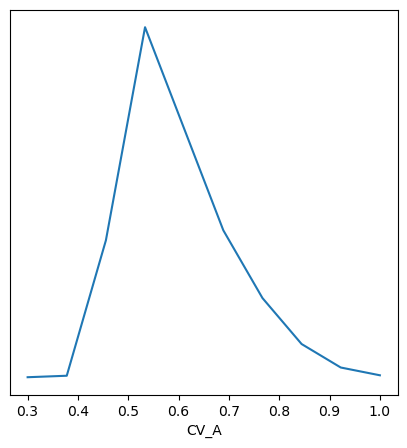

In [70]:
plt.figure(figsize=(5,5))
plt.plot(CV_A,np.sum(joint_posterior,axis=(0,1))*dCA*dCV)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off
plt.xlabel('CV_A')

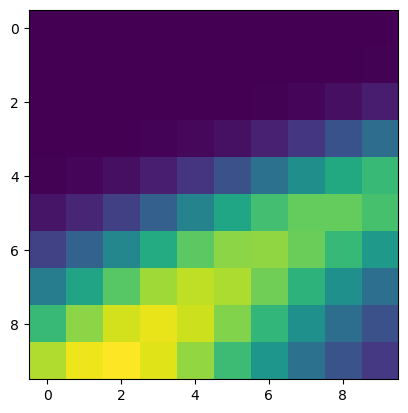

In [71]:
plt.imshow(np.sum(joint_posterior,axis=(2))*dCA*dkv)

In [72]:
k_v.sja[]

SyntaxError: invalid syntax (3023451307.py, line 1)

In [73]:
CV, kv = np.meshgrid(CV_V,k_v,indexing='ij')

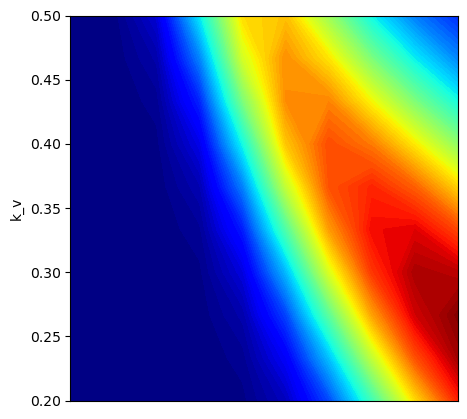

In [74]:
plt.figure(figsize=(5,5))
plt.contourf(CV,kv, np.sum(joint_posterior,axis=(2))*dCV*dkv,levels=100, cmap = 'jet')
#plt.colorbar()
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.ylabel('k_v')

plt.show()

In [75]:
CV, CA = np.meshgrid(CV_V,CV_A,indexing='ij')


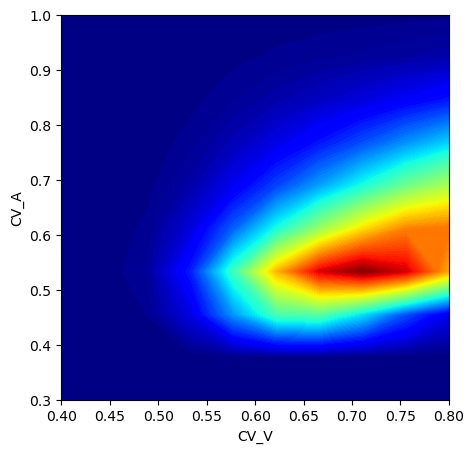

In [80]:
plt.figure(figsize=(5,5))
plt.contourf(CV,CA, np.sum(joint_posterior,axis=(1))*dCV*dCA,levels=100, cmap = 'jet')
plt.xlabel('CV_V')
plt.ylabel('CV_A')

#plt.fontsize(18)
#plt.colorbar()
plt.show()

In [81]:
kv, CA = np.meshgrid(k_v,CV_A,indexing='ij')

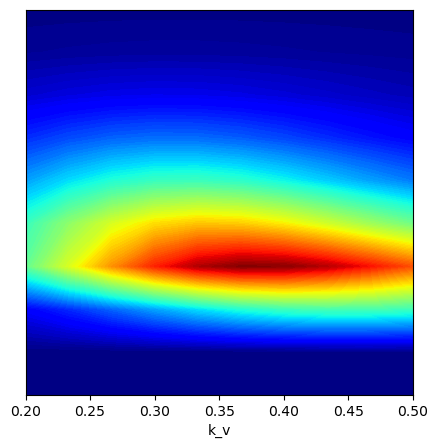

In [82]:
plt.figure(figsize=(5,5))
plt.contourf(kv,CA, np.sum(joint_posterior,axis=(0))*dCV*dCA,levels=100, cmap = 'jet')
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off
plt.xlabel('k_v')
plt.show()

In [83]:
plt.contourf(CV,CA, joint_posterior[:,49,:],levels=100, cmap = 'jet')
plt.colorbar()
plt.show()

IndexError: index 49 is out of bounds for axis 1 with size 10

In [84]:
c1 = CV_V3.reshape(Nx**3)[np.argmax(likelihood)]

In [85]:
c2 = k_v3.reshape(Nx**3)[np.argmax(likelihood)]

In [86]:
c3 = CV_A3.reshape(Nx**3)[np.argmax(likelihood)]

In [87]:
print(c1,c2,c3)

0.5777777777777778 0.43333333333333335 0.5333333333333333


In [88]:
X_test_split.iloc[:,0:6]

,CV_ventricles,k_ventricles,k_FEC,CV_atria,k_atria,k_BB
40,0.727054,0.407562,2.2459,0.515077,0.332962,4.3567


In [89]:
newdf

,CV_ventricles,k_ventricles,CV_atria,Mode1,Mode2,Mode3,Mode4,Mode5,Mode6,Mode7,Mode8,Mode9
0,0.4,0.2,0.300000,14.528402,16.32897,-5.26904,31.653975,7.173021,17.494031,-1.362727,-2.515712,3.296703
1,0.4,0.2,0.377778,14.528402,16.32897,-5.26904,31.653975,7.173021,17.494031,-1.362727,-2.515712,3.296703
2,0.4,0.2,0.455556,14.528402,16.32897,-5.26904,31.653975,7.173021,17.494031,-1.362727,-2.515712,3.296703
3,0.4,0.2,0.533333,14.528402,16.32897,-5.26904,31.653975,7.173021,17.494031,-1.362727,-2.515712,3.296703
4,0.4,0.2,0.611111,14.528402,16.32897,-5.26904,31.653975,7.173021,17.494031,-1.362727,-2.515712,3.296703
...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.8,0.5,0.688889,14.528402,16.32897,-5.26904,31.653975,7.173021,17.494031,-1.362727,-2.515712,3.296703
996,0.8,0.5,0.766667,14.528402,16.32897,-5.26904,31.653975,7.173021,17.494031,-1.362727,-2.515712,3.296703
997,0.8,0.5,0.844444,14.528402,16.32897,-5.26904,31.653975,7.173021,17.494031,-1.362727,-2.515712,3.296703
998,0.8,0.5,0.922222,14.528402,16.32897,-5.26904,31.653975,7.173021,17.494031,-1.362727,-2.515712,3.296703


In [90]:
newdf.iloc[0,[0,1,2]]=[c1,c2,c3]

In [91]:
newdf.iloc[0]

CV_ventricles     0.577778
k_ventricles      0.433333
CV_atria          0.533333
Mode1            14.528402
Mode2            16.328970
Mode3            -5.269040
Mode4            31.653975
Mode5             7.173021
Mode6            17.494031
Mode7            -1.362727
Mode8            -2.515712
Mode9             3.296703
Name: 0, dtype: float64

In [92]:
emulator.predict(newdf.iloc[[0]])

tensor([[144.6453,  93.5872]], grad_fn=<PermuteBackward0>)

In [93]:
y_test_split

,"(A_TAT,)","(V_TAT,)"
40,153.388,84.0788


In [ ]:
newdf.iloc[0]

In [ ]:
y_test_split

In [ ]:
dCV

In [ ]:
y_test_split

In [ ]:
import emcee
ndim = 3
nwalkers = 10
p0 = np.random.multivariate_normal((0.6,0.3,0.7), 0.01*np.identity(3), size=(nwalkers))
y_val = y_test_split

In [ ]:
p0

In [ ]:
(mll1(emulator.models[1](torch.tensor(newdf_norm.iloc[[i]].values).float()),torch.tensor(y_rep_norm.iloc[i,1]).float()).detach().numpy())+(mll0(emulator.models[0](torch.tensor(newdf_norm.iloc[[i]].values).float()),torch.tensor(y_rep_norm.iloc[i,0 ]).float()).detach().numpy())

In [ ]:
def log_prior(theta):
    CV, k, CA = theta
    if 0.4< CV < 0.8 and 0.2 < k < 0.5 and 0.3 < CA < 1.0:
        return 0.0
    return -np.inf

In [ ]:
np.min(newdf,axis=0)

In [ ]:
np.max(newdf,axis=0)

In [ ]:
def log_likelihood(x,emulator,y_val):
    
    x2 = newdf.iloc[[0]]
    x2.iloc[0,0:3] = x
    x2,y2 = emulator.normalise_test_data(x2,y_val)
    return (mll1(emulator.models[1](torch.tensor(x2.values).float()),torch.tensor(y2.iloc[0,1]).float()).detach().numpy())+(mll0(emulator.models[0](torch.tensor(x2.values).float()),torch.tensor(y2.iloc[0,0]).float()).detach().numpy())

In [ ]:
x = [0.5,0.4,0.4]

In [ ]:
x2 = newdf.iloc[[0]]
x2.iloc[0,0:3] = x
x2,y2 = emulator.normalise_test_data(x2,y_val)

In [ ]:
def log_prob(theta, emulator,y_val):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta,emulator, y_val)

In [ ]:
log_likelihood([0.5,0.4,0.4], emulator,y_val)

In [ ]:
log_prob([0.5,0.4,0.4], emulator,y_val)

In [ ]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[emulator,y_val])

In [ ]:
t1_start = process_time() 

sampler.run_mcmc(p0, 50000)

t1_stop = process_time() 
   
print("Elapsed time:", t1_stop, t1_start)  
   
print("Elapsed time during the whole program in seconds:", 
                                         t1_stop-t1_start)  

In [ ]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["CV_V", "k_V", "CV_A"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [ ]:
tau = sampler.get_autocorr_time()
print(tau)

In [ ]:
flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True)
print(flat_samples.shape)

In [ ]:
X_test_split.iloc[:,[0,1,3]].values.squeeze()

In [ ]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=X_test_split.iloc[:,[0,1,3]].values.squeeze()
);

In [ ]:
emulator2 = GPE.ensemble(new_X,new_Y,mean_func="linear",training_iter=500)

In [ ]:
new_X.min(axis=0)

In [ ]:
new_X.max(axis=0)

In [ ]:
def log_prior(theta):
    CV, k, kf, CA, ka, kb = theta
    if 0.4< CV < 0.8 and 0.2 < k < 0.5 and 0.3 < CA < 1.0 and 1.2<kf<8.4 and 0.2 < ka < 0.5 and 1.0 < kb < 5.7:
        return 0.0
    return -np.inf

In [ ]:
def log_likelihood(x,emulator,y_val):
    
    x2 = newdf.iloc[[0]]
    x2.iloc[0,0:6] = x
    x2,y2 = emulator.normalise_test_data(x2,y_val)
    return (mll1(emulator.models[1](torch.tensor(x2.values).float()),torch.tensor(y2.iloc[0,1]).float()).detach().numpy())+(mll0(emulator.models[0](torch.tensor(x2.values).float()),torch.tensor(y2.iloc[0,0]).float()).detach().numpy())

In [ ]:
ndim = 6
nwalkers = 12
p0 = np.random.multivariate_normal((0.6,0.3,5,0.7,0.3,3.0), 0.001*np.identity(6), size=(nwalkers))
y_val = y_test_split

In [ ]:
newdf = X_test_split

In [ ]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[emulator2,y_val])

In [ ]:
emulator2.predict(X_test_split)
t1_start = process_time() 

sampler.run_mcmc(p0, 50000)

t1_stop = process_time() 
   
print("Elapsed time:", t1_stop, t1_start)  
   
print("Elapsed time during the whole program in seconds:", 
                                         t1_stop-t1_start)  

In [ ]:
flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True)
print(flat_samples.shape)

In [ ]:
import corner

fig = corner.corner(
    flat_samples, labels = x_labels[0:6],  truths=X_test_split.iloc[:,0:6].values.squeeze()
);

 # Lasso tests

In [ ]:
x_labels=pd.read_csv(r'C:\Users\pmzcwl\Documents\GitHub\Calibration\shared_simulations\EP_healthy\input\xlabels_EP.txt',delim_whitespace=True,header=None)

inputData_0 = pd.read_csv("/Users/pmzcwl/Documents/GitHub/Calibration/shared_simulations/EP_healthy/01/X_EP.txt",index_col=None,delim_whitespace=True,header=None).values
outputData_0 = pd.read_csv("/Users/pmzcwl/Documents/GitHub/Calibration/shared_simulations/EP_healthy/01/Y.txt",index_col=None,delim_whitespace=True,header=None).values

new_X = pd.DataFrame(inputData_0)
new_Y = pd.DataFrame(outputData_0)

new_X.columns=x_labels


new_Y.columns = y_labels


In [ ]:
x_labels

In [ ]:
new_labels = x_labels.values
for i,l in enumerate(new_labels):
    new_labels[i] = str(l)+"_one_over"
    

In [ ]:
new_X_one_over = 1/new_X
new_X_one_over.columns = new_labels[0:15]
new_X_one_over

In [ ]:
new_X_adjust=pd.concat([new_X,new_X_one_over],axis=1)

In [ ]:
new_X_adjust

In [ ]:
X.mean(axis=0)


In [ ]:
# split original dataset in training, validation and testing sets
X=new_X_adjust
y=new_Y

X = (X-X.mean(axis=0))/X.std(axis=0)
y = (y-y.mean(axis=0))/y.std(axis=0)
X_n_train, X_n_test, y_n_train, y_n_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=seed
)

In [ ]:
X

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
import numpy as np
model = Pipeline([('poly', PolynomialFeatures(degree=1)),
                  ('lasso', Lasso(alpha=0.01,max_iter=10000))])
# fit to an order-3 polynomial data
model = model.fit(X_n_train, y_n_train)
model.named_steps['lasso'].coef_

In [ ]:
model.score(X_n_train,y_n_train)

In [ ]:
model.score(X_n_test,y_n_test)

In [ ]:
coefficients.shape

In [ ]:
new_X_columns=new_X_adjust.columns.insert(0,'intercept')

In [ ]:
coefficients=pd.DataFrame(model.named_steps['lasso'].coef_)
coefficients.columns = new_X_columns

In [ ]:
coefficients

In [ ]:
len(y_labels)

In [ ]:
y_labels

In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(coefficients,cmap='magma_r')
ax.set_yticks(np.arange(len(y_labels)),labels=y_labels.values)
ax.set_xticks(np.arange(len(new_X_columns)), labels=new_X_columns)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

In [ ]:
# split original dataset in training, validation and testing sets
X=new_X_adjust
y=new_Y

#X = (X-X.mean(axis=0))/X.std(axis=0)
#y = (y-y.mean(axis=0))/y.std(axis=0)
X_n_train, X_n_test, y_n_train, y_n_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=seed
)

In [ ]:
emulator_standard = GPE.ensemble(X_n_train.iloc[:,0:6],y_n_train,mean_func="linear",training_iter=500)
emulator_one_over = GPE.ensemble(X_n_train.iloc[:,6:12],y_n_train,mean_func="linear",training_iter=500)

In [ ]:
emulator_standard.R2(X_n_test.iloc[:,0:6],y_n_test)

In [ ]:
emulator_standard.MSE(X_n_test.iloc[:,0:6],y_n_test)

In [ ]:
emulator_one_over.R2(X_n_test.iloc[:,6:12],y_n_test)

In [ ]:
emulator_one_over.MSE(X_n_test.iloc[:,6:12],y_n_test)